In [ ]:
# GIVEN DEPENDENCY ISSUES RUN ON GOOGLE COLAB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.9 MB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from catboost import CatBoostClassifier
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import label_binarize

import shap

%config InlineBackend.figure_format = 'retina'

In [ ]:
os.chdir("drive/MyDrive/Machine Learning 2")


In [ ]:
from notebook import notebookapp
import urllib
import json
import ipykernel
from shutil import copy2

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory
    return None


def copy_current_nb(new_name):
    nb = notebook_path()
    if nb:
        new_path = os.path.join(os.path.dirname(nb), new_name+'.ipynb')
        copy2(nb, new_path)
    else:
        print("Current notebook path cannot be determined.")

In [ ]:
df = pd.read_csv('Data/cover_type_engineered.csv')

In [ ]:
df = df.loc[:, [col for col in df if not col.startswith('Cover_Type_')]]
X = df.drop(columns=['Cover_Type', 'Aspect_Sector'])
y = df['Cover_Type'] - 1

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M")

warnings.filterwarnings("ignore", category=FutureWarning, module="pandas.api.types")

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Define the estimator
estimator = CatBoostClassifier(loss_function='MultiClass', verbose=False)

# Define hyperparameters for tuning
hyperparameters = {
    "iterations": stats.randint(80, 200),
    "learning_rate": stats.uniform(0.1, 0.35),
    "depth": stats.randint(7, 15),
    "l2_leaf_reg": stats.uniform(1, 10),
    "border_count": stats.randint(50, 200),
    "bagging_temperature": stats.uniform(0, 1)
}

# Define the RandomizedSearchCV parameters
random_search = RandomizedSearchCV(estimator,
                                   param_distributions=hyperparameters,
                                   scoring='accuracy',
                                   return_train_score=True,
                                   n_iter=100,
                                   cv=5,
                                   verbose=10,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV
try:
    random_search.fit(X_train, y_train)  # Assuming X_train and y_train are defined
    print("Best parameters found:", random_search.best_params_)
    print("Best score found:", random_search.best_score_)


    # Save results
    results_path = f"./tuning_results/tuning_cat/{timestamp}"
    if not os.path.exists(results_path):
        os.makedirs(results_path)

    # Saving cross-validation results
    cv_results = pd.DataFrame(random_search.cv_results_)
    cv_results_file = f"{timestamp}_results.csv"
    cv_results.to_csv(os.path.join(results_path, cv_results_file), index=False)

    # Save .ipynb
    # copy_current_nb(os.path.join(results_path, 'Evaluation_Notebook'))

    # Save Model
    file_name = f"cat_{timestamp}.pkl"
    pickle.dump(random_search, open(os.path.join(results_path, file_name), "wb"))

    # random_search = pickle.load(open(file_name, "rb"))


except Exception as e:
    print(f"An error occurred during model optimization: {e}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
cv_results.head()

In [ ]:
results_path = f"./tuning_results/tuning_cat/{timestamp}/Assets"
if not os.path.exists(results_path):
    os.makedirs(results_path)

# CV Evaluation

In [ ]:
cv_results.columns

In [ ]:
cv_results.sort_values(by='rank_test_score', ascending=True).head(5)

In [ ]:
sorted_cv = cv_results.sort_values(by='rank_test_score', ascending=True)

# Train vs Test Comparison

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_train_score'], label="Train Score")
plt.plot(sorted_cv['rank_test_score'], sorted_cv['mean_test_score'], label="Validation Score")

plt.grid()
plt.xlabel('Sorted Validation Rank')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Final Rank')
plt.legend(loc='best')

filename = "test_train_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Test Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_test_score', 'split1_test_score', 'split2_test_score',
   'split3_test_score', 'split4_test_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "test_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 3))
fig.suptitle('Train Accuracy by Rank')

ax = fig.add_subplot(111)

plt.boxplot(sorted_cv.iloc[:10, :][['split0_train_score', 'split1_train_score', 'split2_train_score',
   'split3_train_score', 'split4_train_score']].T)
ax.set_xticklabels(range(1, 11))
ax.set_xlabel("Rank")
ax.set_ylabel("Accuracy")

filename = "train_accuracy_by_rank.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
max_params = cv_results.loc[cv_results['rank_test_score'] == 1]
best_params = max_params.params.values[0]

In [ ]:
print(f"Mean Train set, Accuracy = {max_params['mean_train_score'].values[0]:.2f}")
print(f"Mean Validation set, Accuracy = {max_params['mean_test_score'].values[0]:.2f}")

In [ ]:
random_search = pickle.load(open(os.path.join(results_path, file_name), "rb"))
model = random_search.best_estimator_

#model = CATClassifier(**best_params)
#model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

In [ ]:
print(f"Train set, Accuracy = {accuracy_score(y_train, y_train_prediction):.2f}")
print(f"Test set, Accuracy = {accuracy_score(y_test, y_test_prediction):.2f}")

In [ ]:
ind = np.argpartition(model.feature_importances_, -20)[-20:]

features = X.columns[ind]
importance = model.feature_importances_[ind]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(ind)), importance, align='center')
plt.yticks(range(len(ind)), features)
plt.title('Feature Importance CAT')
plt.grid()

filename = "feature_importance.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()

In [ ]:
# TEST
for col in ['param_iterations', 'param_learning_rate', 'param_depth', 'param_l2_leaf_reg', 'param_border_count', 'param_bagging_temperature']:

    plt.figure(figsize=(16, 6))

    m, b = np.polyfit(list(sorted_cv['mean_test_score'].values), list(sorted_cv[col].values), 1)
    plt.plot(sorted_cv['mean_test_score'], m * sorted_cv['mean_test_score'] + b, c='r', label="Regression Line")
    plt.scatter(sorted_cv['mean_test_score'], sorted_cv[col], label=f"{col} Values")

    plt.grid()
    plt.xlabel('Mean Validation Score')
    plt.ylabel('Parameter Value')
    plt.title(col)
    plt.legend(loc='best')


    filename = f"{col}_by_rank.png"
    plt.savefig(os.path.join(results_path, filename))

    plt.show()


# Hyperparameter Evaluation

In [ ]:

def plot_parameters(x_values, title):

    fig, ax1 = plt.subplots(figsize=(16, 6))
    ax2 = ax1.twinx()

    ax1.scatter(x_values, cv_results['mean_test_score'], label='mean_test_score', c='b')
    #ax2.scatter(x_values, cv_results['std_test_score'], label='std_test_score', c='r')

    m, b = np.polyfit(list(x_values.values), list(cv_results['mean_test_score'].values), 1)
    ax1.plot(x_values, m * x_values + b, c='b')

    m, b = np.polyfit(list(x_values.values), list(cv_results['std_test_score'].values), 1)
    ax2.plot(x_values, m * x_values + b, c='r', label='std_test_score')

    ax1.set_title(title)
    ax1.set_xlabel('Parameter Value')
    ax1.set_ylabel('Mean Test Score')
    ax2.set_ylabel('Standard Deviation of Test Score')
    ax1.grid(True)


    # Combine the legends from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    filename = f"{title}_test_score.png"
    plt.savefig(os.path.join(results_path, filename))

    plt.show()





In [ ]:

for param in ['param_iterations', 'param_learning_rate', 'param_depth', 'param_l2_leaf_reg', 'param_border_count', 'param_bagging_temperature']:
    x_values = cv_results[param]
    plot_parameters(x_values, param)

# Plotting Evaluation Metrics (Precision, Recall, F1-Score, AUC-ROC):


In [ ]:

# For multiclass classification, you need to binarize the labels
y_true_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score_bin = label_binarize(y_test_prediction, classes=np.unique(y_test_prediction))

auc_roc = roc_auc_score(y_true_bin, y_score_bin, average='macro')

# Plot Precision-Recall curve for each class
precision = dict()
recall = dict()

plt.figure(figsize=(16, 6))
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(recall[i], precision[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

filename = "precision_recall.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()


# Plot AUC-ROC curve for each class
fpr = dict()
tpr = dict()

plt.figure(figsize=(16, 6))
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    plt.plot(fpr[i], tpr[i], label='Covertype {}'.format(i + 1))

plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC Curve')
plt.legend(loc='best')

filename = "roc_curve.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()


# Partial Dependence

In [ ]:
# potentially iterate over features (and relation ie 0 to 1)

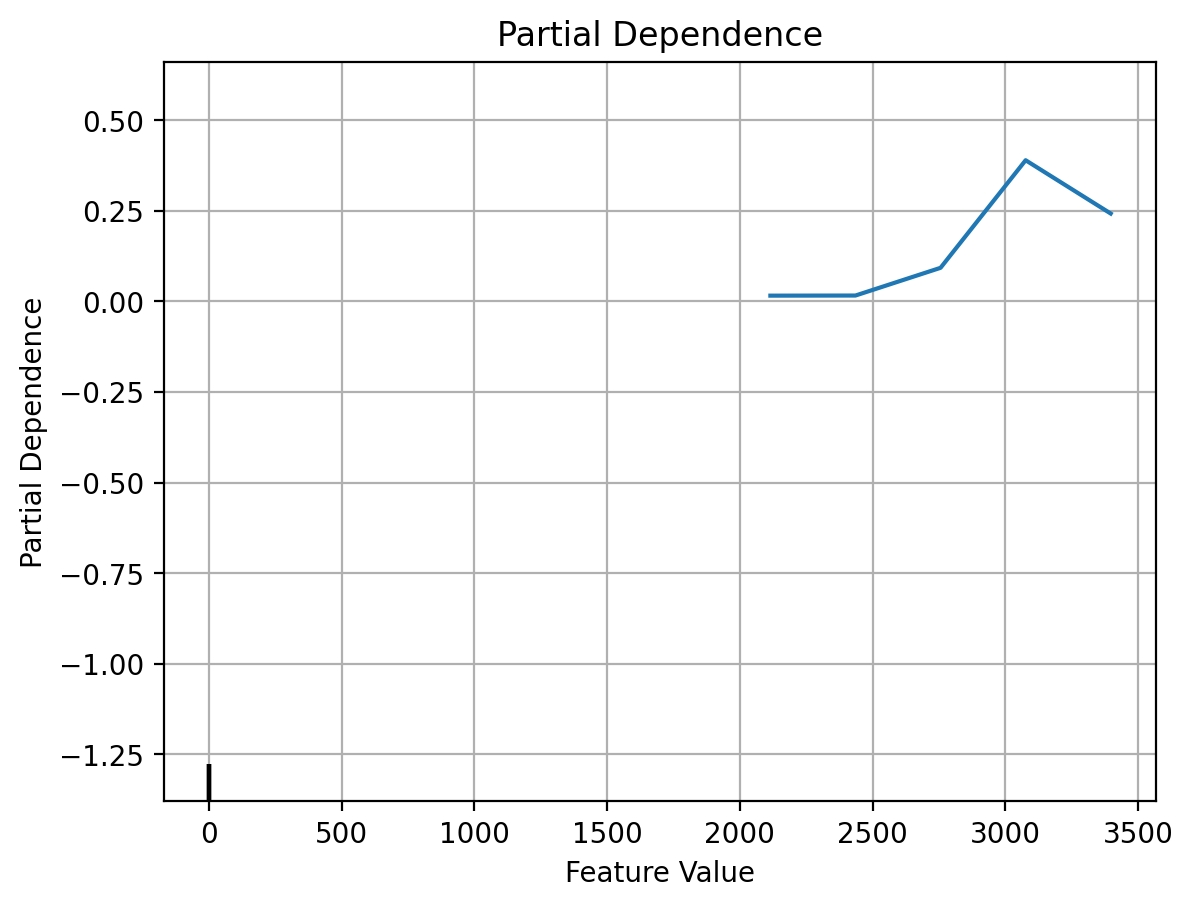

In [ ]:

features, feature_names = [(0,)], [f"Features #{i}" for i in range(X.shape[1])]
deciles = {0: np.linspace(0, 1, num=5)}

pd_results = partial_dependence(
    model, X, features=1, kind="average", grid_resolution=5)

display = PartialDependenceDisplay(
    [pd_results], features=features, feature_names=feature_names,
    target_idx=0, deciles=deciles
)
display.plot(pdp_lim={1: (-1.38, 0.66)})

plt.grid()
plt.xlabel('Feature Value')
plt.ylabel('Partial Dependence')
plt.title('Partial Dependence')

filename = "partial_dependence.png"
plt.savefig(os.path.join(results_path, filename))

plt.show()


# Confusion Matrix

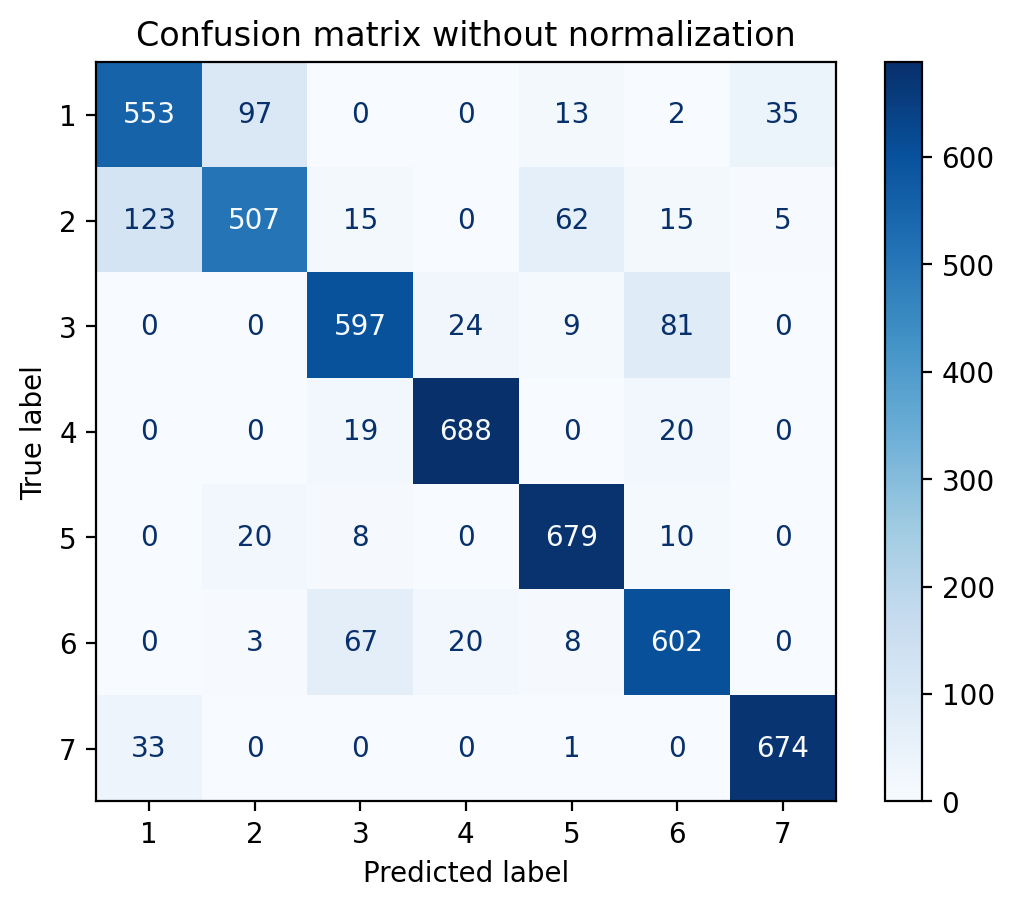

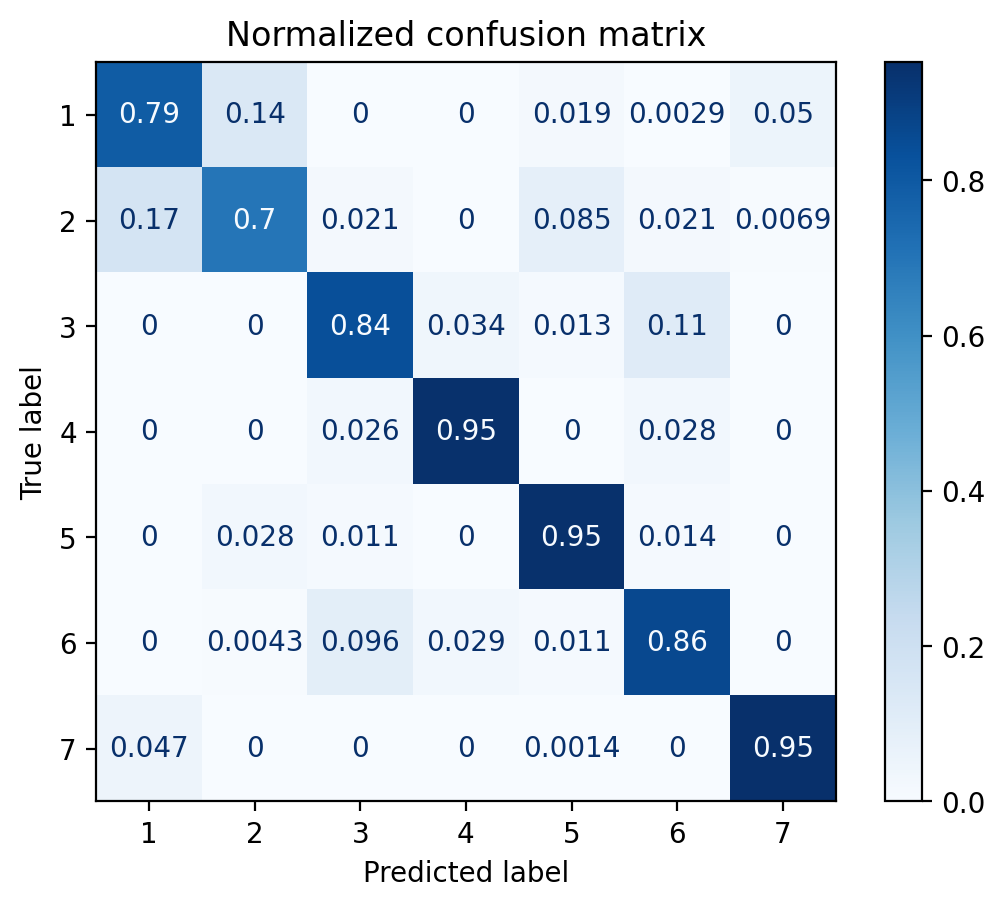

In [ ]:

class_names = np.unique(y)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=class_names + 1,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    png_name = title.lower().replace(" ", "_")
    filename = f"{png_name}.png"
    plt.savefig(os.path.join(results_path, filename))

plt.show()

# Shap Values

In [ ]:
explainer = shap.TreeExplainer(model)
explanation = explainer.shap_values(X_test, check_additivity=False)


In [ ]:
shap.summary_plot(explanation, X_test, plot_type="bar", show=False)

filename = f"shap_summary.png"
plt.savefig(os.path.join(results_path, filename))
plt.close()

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features.
